NPZ: cache/encodec_big_acoustic_pop/items/e3ec83d88807d7c5703d.npz
D=17 T=87 C=4 bpm=138.0 drummer_id=1


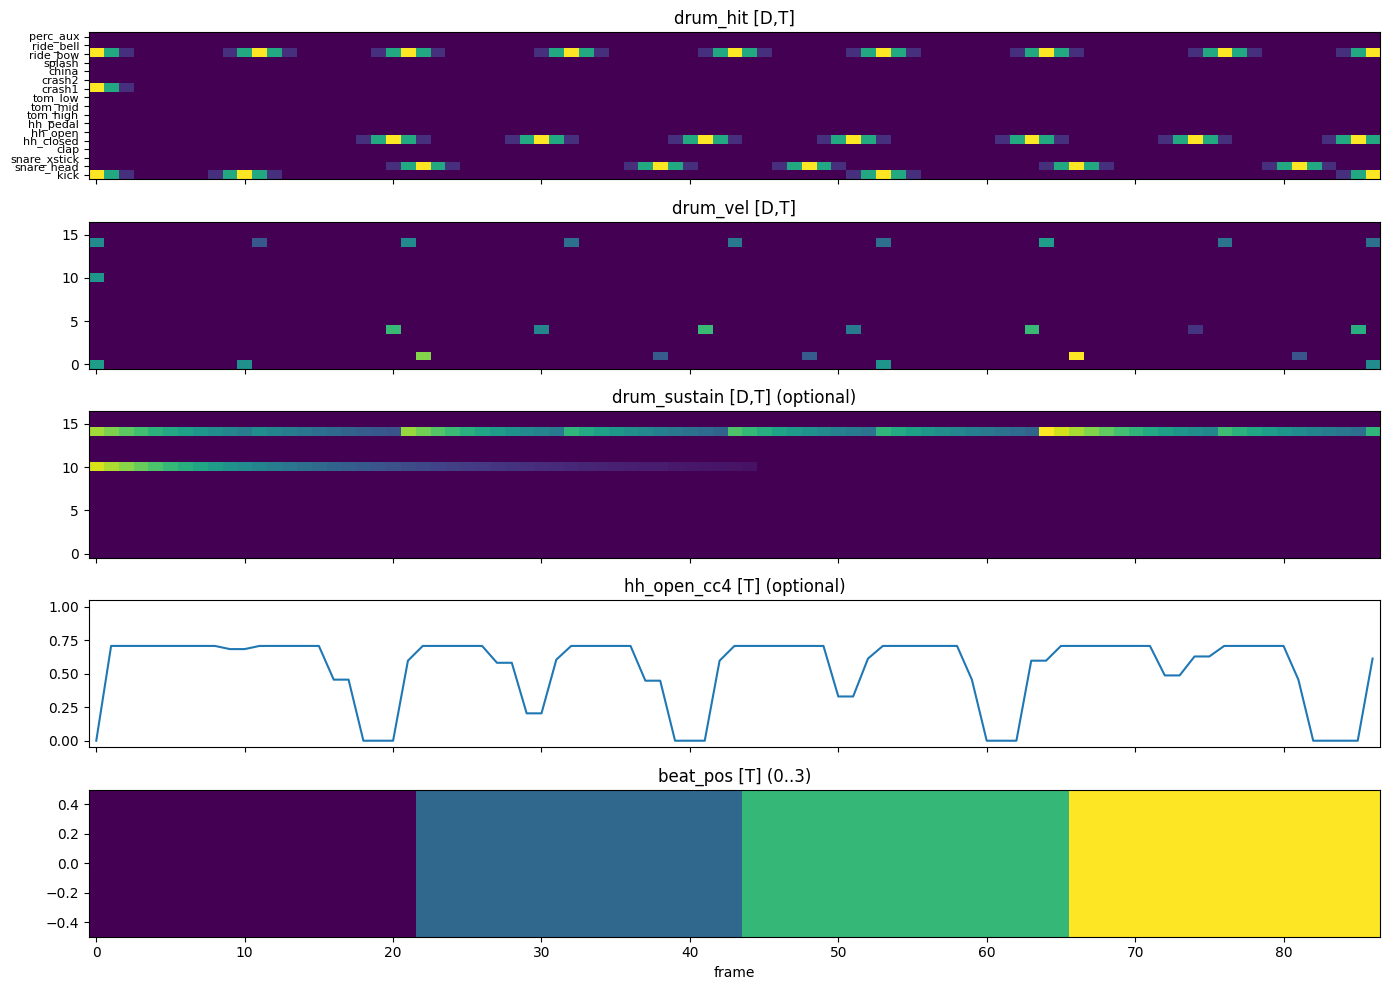

/home/ksoil/.conda/envs/ksoil_torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


used sustain: False used hh_cc4: False
token_acc: 0.3563218414783478 pred shape: (4, 87) tgt shape: (4, 87)


2026-01-26 16:35:17.192260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769438117.207664  782379 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769438117.212714  782379 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769438117.226450  782379 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769438117.226462  782379 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769438117.226463  782379 computation_placer.cc:177] computation placer alr

ref_rs: (27826,) gt_rs: (27826,) pr_rs: (27826,)
Original audio (resampled):


Codec reconstruction from ground-truth tokens (resampled):


Model prediction decoded (resampled):


L1(gt vs ref): 0.004796240944415331
L1(pred vs ref): 0.011109928600490093


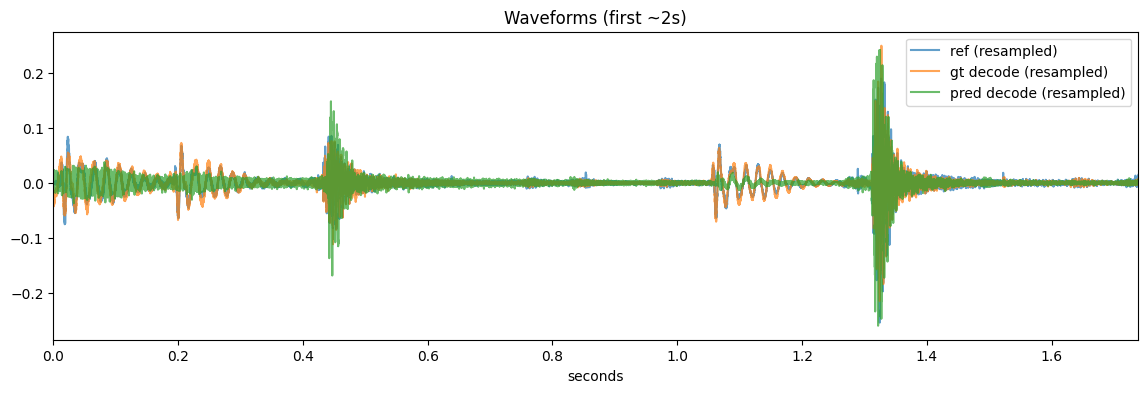

In [1]:
# Cell 1: setup + pick 1 cached item (works with optional sustain / hh_cc4)
from pathlib import Path
import json
import numpy as np
import torch

CACHE_DIR = Path("cache/encodec_big_acoustic_pop")
CKPT_PATH = Path("artifacts/checkpoints/expressivegrid_to_encodec_big.pt")

DEVICE = "cuda:0"         # model forward
DECODE_DEVICE = "cuda:0"  # codec decode (set to "cpu" if VRAM is tight)
EVAL_SR = 16000
PAD_ID = 2048

manifest = sorted(CACHE_DIR.glob("manifest_midigroove_test_*.jsonl"))[0]
rec = json.loads(manifest.read_text().splitlines()[0])
npz_path = Path(rec["npz"])
print("NPZ:", npz_path)

with np.load(npz_path, allow_pickle=False) as d:
    ex = {k: np.asarray(d[k]) for k in d.files}

# conditioning lanes (sustain + hh_cc4 are optional and default to zeros)
drum_hit = ex["drum_hit"].astype(np.float32)                                # [D,T]
drum_vel = ex.get("drum_vel", np.zeros_like(drum_hit)).astype(np.float32)   # [D,T]
drum_sus = ex.get("drum_sustain", np.zeros_like(drum_hit)).astype(np.float32)  # [D,T]
hh_cc4   = ex.get("hh_open_cc4", np.zeros((drum_hit.shape[1],), np.float32)).astype(np.float32)  # [T]
beat_pos = ex["beat_pos"].astype(np.int64)                                  # [T]
bpm = float(ex.get("bpm", 120.0))
drummer_id = int(ex.get("drummer_id", 0))

tgt = ex["tgt"].astype(np.int64)                                            # [C,T] ground-truth codec tokens
D, T = drum_hit.shape
C = int(tgt.shape[0])
print(f"D={D} T={T} C={C} bpm={bpm} drummer_id={drummer_id}")

# Cell 2: visualize inputs (always shows sustain/hh lanes even if not used)
try:
    import matplotlib.pyplot as plt
except Exception as e:
    raise RuntimeError("Install matplotlib in this env (e.g. `pip install matplotlib`)") from e

from data.midigroove_encodec_dataset import CHANNELS

fig, axs = plt.subplots(5, 1, figsize=(14, 10), sharex=True)

axs[0].imshow(drum_hit, aspect="auto", origin="lower", interpolation="nearest")
axs[0].set_title("drum_hit [D,T]")
axs[0].set_yticks(range(len(CHANNELS)))
axs[0].set_yticklabels(CHANNELS, fontsize=8)

axs[1].imshow(drum_vel, aspect="auto", origin="lower", interpolation="nearest")
axs[1].set_title("drum_vel [D,T]")

axs[2].imshow(drum_sus, aspect="auto", origin="lower", interpolation="nearest")
axs[2].set_title("drum_sustain [D,T] (optional)")

axs[3].plot(hh_cc4)
axs[3].set_ylim(-0.05, 1.05)
axs[3].set_title("hh_open_cc4 [T] (optional)")

axs[4].imshow(beat_pos[None, :], aspect="auto", origin="lower", interpolation="nearest", vmin=0, vmax=3)
axs[4].set_title("beat_pos [T] (0..3)")
axs[4].set_xlabel("frame")

plt.tight_layout()
plt.show()

# Cell 3: run checkpoint on this item -> predicted tokens (respects ckpt feature flags)
from midigroove_poc import expressivegrid as eg

ckpt = torch.load(CKPT_PATH, map_location="cpu")
cfg = ckpt.get("cfg", {}) if isinstance(ckpt.get("cfg", {}), dict) else {}
num_codebooks = int(ckpt["num_codebooks"])
in_dim = int(ckpt["in_dim"])

include_sustain = bool(cfg.get("include_sustain", False))
include_hh_cc4 = bool(cfg.get("include_hh_cc4", False))

pieces = [drum_hit, drum_vel]
if include_sustain:
    pieces.append(drum_sus)
if include_hh_cc4:
    pieces.append(hh_cc4[None, :])

grid = np.concatenate(pieces, axis=0).astype(np.float32)  # [F,T]
assert grid.shape[0] == in_dim and grid.shape[1] == T, (grid.shape, in_dim, T)

model = eg._build_model(num_codebooks=num_codebooks, in_dim=in_dim, cfg=cfg)
model.load_state_dict(ckpt["model"], strict=True)
model.to(torch.device(DEVICE)).eval()

grid_t = torch.from_numpy(grid).unsqueeze(0).to(DEVICE)            # [1,F,T]
beat_pos_t = torch.from_numpy(beat_pos).unsqueeze(0).to(DEVICE)    # [1,T]
bpm_t = torch.tensor([bpm], dtype=torch.float32, device=DEVICE)    # [1]
drummer_id_t = torch.tensor([drummer_id], dtype=torch.long, device=DEVICE)  # [1]
valid_mask_t = torch.ones((1, T), dtype=torch.bool, device=DEVICE)

with torch.inference_mode():
    logits = model(grid=grid_t, beat_pos=beat_pos_t, bpm=bpm_t, drummer_id=drummer_id_t, valid_mask=valid_mask_t)  # [1,C,T,V]
    pred = logits.argmax(dim=-1).squeeze(0).to(torch.long).cpu()  # [C,T]

tgt_t = torch.from_numpy(tgt).to(torch.long)  # [C,T]
pred = torch.where(pred == PAD_ID, torch.zeros_like(pred), pred)
tgt_t = torch.where(tgt_t == PAD_ID, torch.zeros_like(tgt_t), tgt_t)

tok_acc = (pred == tgt_t).float().mean().item()
print("used sustain:", include_sustain, "used hh_cc4:", include_hh_cc4)
print("token_acc:", tok_acc, "pred shape:", tuple(pred.shape), "tgt shape:", tuple(tgt_t.shape))

# Cell 4: decode audio (prediction vs gt tokens) and compare to original resampled audio segment
from IPython.display import Audio, display
from data.codecs import decode_tokens_to_audio
from midigroove_poc.eval import _load_audio_segment, _resample_linear

audio_path = Path(str(ex["audio_path"].item()))
sr_native = int(ex["sr"].item())
start_sec = float(ex["start_sec"].item())
window_seconds = float(ex["window_seconds"].item())
start_sample = int(round(start_sec * sr_native))
window_samples = int(round(window_seconds * sr_native))

ref, sr_ref = _load_audio_segment(audio_path, start_sample=start_sample, num_samples=window_samples)
ref_rs = _resample_linear(ref, sr_ref, EVAL_SR)

audio_gt_b1, sr_gt = decode_tokens_to_audio(tgt_t, encoder_model="encodec", device=DECODE_DEVICE)
audio_pr_b1, sr_pr = decode_tokens_to_audio(pred,  encoder_model="encodec", device=DECODE_DEVICE)
gt_rs = _resample_linear(audio_gt_b1[0], sr_gt, EVAL_SR)
pr_rs = _resample_linear(audio_pr_b1[0], sr_pr, EVAL_SR)

N = min(ref_rs.size, gt_rs.size, pr_rs.size)
ref_rs, gt_rs, pr_rs = ref_rs[:N], gt_rs[:N], pr_rs[:N]

print("ref_rs:", ref_rs.shape, "gt_rs:", gt_rs.shape, "pr_rs:", pr_rs.shape)

print("Original audio (resampled):")
display(Audio(ref_rs, rate=EVAL_SR))
print("Codec reconstruction from ground-truth tokens (resampled):")
display(Audio(gt_rs, rate=EVAL_SR))
print("Model prediction decoded (resampled):")
display(Audio(pr_rs, rate=EVAL_SR))

# Cell 5: quick waveform comparison plots
import matplotlib.pyplot as plt
import numpy as np

def l1(a, b): return float(np.mean(np.abs(a - b)))
print("L1(gt vs ref):", l1(gt_rs, ref_rs))
print("L1(pred vs ref):", l1(pr_rs, ref_rs))

t = np.arange(N) / float(EVAL_SR)
plt.figure(figsize=(14,4))
plt.plot(t, ref_rs, label="ref (resampled)", alpha=0.7)
plt.plot(t, gt_rs, label="gt decode (resampled)", alpha=0.7)
plt.plot(t, pr_rs, label="pred decode (resampled)", alpha=0.7)
plt.xlim(0, min(t[-1], 2.0))
plt.legend()
plt.title("Waveforms (first ~2s)")
plt.xlabel("seconds")
plt.show()
